In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
from functools import partial
from saveAndLoad import *
from functools import partial
import math
import torch.nn.functional as F
import torch.nn as nn
import pandas as pd
import h5py
from sklearn.model_selection import ShuffleSplit

import torch.distributed as dist
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP, MixedPrecision, CPUOffload
from torch.distributed.fsdp import (
    StateDictType,
    FullStateDictConfig
)
from torch.utils.data import DistributedSampler, DataLoader
import os
from torch.amp import autocast, GradScaler
from torch.distributions import Beta

import time as time_
from contextlib import nullcontext
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, LlamaForCausalLM, AutoModelForMaskedLM, AutoModel, get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, PrefixTuningConfig, TaskType
import torch, torch.nn as nn

from esm.sdk.api import ESM3InferenceClient, ESMProtein, SamplingConfig, LogitsConfig
from esm.models.esm3 import ESM3
from esm.models.esmc import ESMC
from torch.utils.data import DataLoader, Subset, Dataset, DistributedSampler

/home/dandreas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Cross Attention

In [2]:
class MLP(nn.Module):

    def __init__(self, config, use_dropout=True, d = 'emb'):
        super().__init__()
        assert d in ['emb', 'input'], "d must be either 'emb' or 'input'"
        d = config.emb_dim if d == 'emb' else config.input_dim
        self.c_fc    = nn.Linear(d, 4 * d, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * d, d, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)
        self.use_dropout = use_dropout

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        if self.use_dropout: x = self.dropout(x)
        return x

class Block_CrossAttentionResampler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.norm_q = config.norm_fn(config.input_dim)
        self.norm_k = config.norm_fn(config.input_dim)
        self.norm_mlp = config.norm_fn(config.input_dim)
        self.lin = nn.Linear(config.input_dim, config.input_dim)
        self.mlp = MLP(config, d='input')

        self.resampler = nn.MultiheadAttention(embed_dim=config.input_dim, 
                                            num_heads=config.num_heads, 
                                            dropout=config.dropout, 
                                            batch_first=True)

    def forward(self, x):
        seq, q, key_padding_mask = x
        q_norm =    self.norm_q(q)
        seq_norm =  self.norm_k(seq)
        x = (seq_norm, q_norm, key_padding_mask)
        resampled = self.resampler(x)
        resampled = self.lin(resampled)
        q = q + resampled
        q = self.norm_mlp(q)
        q = q + self.mlp(q)
        return q

class CrossAttentionResampler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.query = nn.Embedding(config.n_resampled_tokens, config.input_dim)
        self.blocks = nn.ModuleList([
            Block_CrossAttentionResampler(config)
            for _ in range(config.n_cross_attention_resampler_blocks)
        ])
        
    def forward(self, x):
        seq, key_padding_mask = x
        B, seq_len, emb_dim = seq.shape
        q = self.query(torch.arange(self.query.num_embeddings, device=seq.device))
        q = q.unsqueeze(0).expand(B, -1, -1)
        for block in self.blocks:
            x = (seq, q, key_padding_mask)
            q = block(x)
        return q


class MutantResampler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.resampler = CrossAttentionResampler(config)
        self.lm = AutoModelForCausalLM.from_pretrained(
            config.lm_name,
            torch_dtype=config.torch_dtype,
            device_map=config.device_map,
            gradient_checkpointing=True
        )

    def forward(self, x):
        # seq, key_padding_mask = x
        mut_repr = self.resampler(x)
        lm_output = self.lm(mut_repr)
        return lm_output

# Dataset

In [22]:
training_data[training_data['MutationType']=='Substitution']

,HGNC_ID,Gene,Assembly,Mutated Sequence,Reference Sequence,affected_aa_start,affected_ref_aa_end,affected_mut_aa_end,cropped mut seq,cropped ref seq,Phenotypes,ClinicalSignificance,MutationType,Levenshtein,interpro_ids,Description,DescriptionSimple,label
18,HGNC:15979,TP63,GRCh37,MNFETSRCATLQYCPDPYIQRFVETPAHFSWKESYYRSTMSQSTQT...,MNFETSRCATLQYCPDPYIQRFVETPAHFSWKESYYRSTMSQSTQT...,310.0,311.0,311.0,MNFETSRCATLQYCPDPYIQRFVETPAHFSWKESYYRSTMSQSTQT...,MNFETSRCATLQYCPDPYIQRFVETPAHFSWKESYYRSTMSQSTQT...,TP63-Related Spectrum Disorders,Pathogenic,Substitution,1,"['IPR002117', 'IPR057064', 'IPR011615', 'IPR00...",substitution (small; 1 aa) in TP63; Clinical S...,substitution (small; 1 aa) in TP63; Clinical S...,1
19,HGNC:1092,FOXL2,GRCh37,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,65.0,66.0,66.0,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,NaN,Pathogenic,Substitution,1,"['IPR001766', 'IPR018122', 'IPR050211', 'IPR04...",substitution (small; 1 aa) in FOXL2; Clinical ...,substitution (small; 1 aa) in FOXL2; Clinical ...,1
20,HGNC:1092,FOXL2,GRCh37,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,74.0,75.0,75.0,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,"Blepharophimosis, ptosis, and epicanthus inver...",Pathogenic,Substitution,1,"['IPR001766', 'IPR050211', 'IPR047515', 'IPR03...",substitution (small; 1 aa) in FOXL2; Clinical ...,substitution (small; 1 aa) in FOXL2; Clinical ...,1
21,HGNC:1092,FOXL2,GRCh37,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,123.0,124.0,124.0,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,MMASYPEPEDAAGALLAPETGRTVKEPEGPPPSPGKGGGGGGGTAP...,NaN,Likely pathogenic,Substitution,1,"['IPR001766', 'IPR050211', 'IPR047515', 'IPR03...",substitution (small; 1 aa) in FOXL2; Clinical ...,substitution (small; 1 aa) in FOXL2; Clinical ...,1
26,HGNC:794,ATIC,GRCh37,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...,571.0,572.0,572.0,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...,MAPGQLALFSVSDKTGLVEFARNLTALGLNLVASGGTAKALRDAGL...,ATIC-related disorder,Benign/Likely benign,Substitution,1,"['IPR024051', 'IPR002695', 'IPR016193']",substitution (small; 1 aa) in ATIC; Clinical S...,substitution (small; 1 aa) in ATIC; Clinical S...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114493,HGNC:4933,HLA-C,GRCh38,MRVMAPRALLLLLSGGLALTETWTCSHSMRYFDTAVSRPGRGEPRF...,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...,23.0,24.0,24.0,MRVMAPRALLLLLSGGLALTETWTCSHSMRYFDTAVSRPGRGEPRF...,MRVMAPRALLLLLSGGLALTETWACSHSMRYFDTAVSRPGRGEPRF...,NaN,Likely benign,Substitution,1,['IPR050208'],substitution (small; 1 aa) in HLA-C; Clinical ...,substitution (small; 1 aa) in HLA-C; Clinical ...,0
114494,HGNC:4932,HLA-B,GRCh38,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,132.0,133.0,133.0,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,NaN,Benign,Substitution,1,"['IPR050208', 'IPR011161', 'IPR011162']",substitution (small; 1 aa) in HLA-B; Clinical ...,substitution (small; 1 aa) in HLA-B; Clinical ...,0
114495,HGNC:4948,HLA-DRB1,GRCh38,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,259.0,260.0,260.0,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,MVCLKLPGGSCMTALTVTLMVLSSPLALSGDTRPRFLWQPKRECHF...,NaN,Likely benign,Substitution,1,[],substitution (small; 1 aa) in HLA-DRB1; Clinic...,substitution (small; 1 aa) in HLA-DRB1; Clinic...,0
114498,HGNC:4932,HLA-B,GRCh38,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,122.0,123.0,123.0,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVS

In [3]:
#----------------Dataset does the tokenization----------------
def _batch_encode(tokenizer, seqs, batch_size=256, desc="tokenizing"):
    """Return list[dict] where each dict has python lists (no tensors) per sample."""
    out = []
    for i in tqdm(range(0, len(seqs), batch_size), desc=desc, leave=False):
        chunk = seqs[i:i+batch_size]
        enc = tokenizer(chunk, return_tensors=None)  # dict of lists
        # split back into per-sample dicts (keep lists so .pad() works later)
        n = len(chunk)
        keys = list(enc.keys())
        for j in range(n):
            out.append({k: enc[k][j] for k in keys})
    return out

class DatasetFromStrings(Dataset):
    def __init__(self, texts, mutations, references, config):
        assert len(texts) == len(mutations) == len(references)
        self.texts = texts
        self.mutations = mutations
        self.references = references
        self.config = config
        bs = getattr(config, "tokenize_batch_size", 256)

        # ---- TEXT ----
        if config.text_model.startswith("thomas-sounack/"):
            self.text_tokenizer = AutoTokenizer.from_pretrained(config.text_model, use_fast=True)
            self.text_tokens = _batch_encode(self.text_tokenizer, texts, batch_size=bs, desc="Text tokenizing")
        else:
            raise ValueError(f'unsupported text model: {config.text_model}')

        # ---- PROTEIN ----
        if config.plm_model in ['esm3', 'esmC']:
            # ESMProtein doesn't batch the same way; show per-item tqdm
            self.plm_tokenizer = ESMProtein
            self.mut_tokens = [self.plm_tokenizer(sequence=s) for s in tqdm(mutations, desc="Protein (mut) tokenizing", leave=False)]
            self.ref_tokens = [self.plm_tokenizer(sequence=s) for s in tqdm(references, desc="Protein (ref) tokenizing", leave=False)]
        elif config.plm_model == 'esm2':
            checkpoint = 'facebook/esm2_t30_150M_UR50D'
            self.plm_tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
            self.mut_tokens = _batch_encode(self.plm_tokenizer, mutations,  batch_size=bs, desc="Protein (mut) tokenizing")
            self.ref_tokens = _batch_encode(self.plm_tokenizer, references, batch_size=bs, desc="Protein (ref) tokenizing")
        else:
            raise ValueError(f'unsupported plm model: {config.plm_model}')

    def __len__(self): 
        return len(self.texts)

    def __getitem__(self, i):
        text_feats = {k: v for k, v in self.text_tokens[i].items()}  # lists
        if self.config.plm_model == 'esm2':
            mut_feats  = {k: v for k, v in self.mut_tokens[i].items()}
            ref_feats  = {k: v for k, v in self.ref_tokens[i].items()}
        else:
            mut_feats = self.mut_tokens[i]
            ref_feats = self.ref_tokens[i]
        return {"text": text_feats, "mut": mut_feats, "ref": ref_feats}
    
class Collator_DatasetFromStrings:
    def __init__(self, text_tokenizer, seq_tokenizer):
        self.text_tokenizer = text_tokenizer
        self.seq_tokenizer = seq_tokenizer
    def __call__(self, batch):
        text_list = [b["text"] for b in batch]             # each is dict of [L]
        mut_list  = [b["mut"]  for b in batch]
        ref_list  = [b["ref"]  for b in batch]
        text = self.text_tokenizer.pad(text_list, return_tensors="pt")  # -> [B, L]
        mut  = self.seq_tokenizer.pad(mut_list,  return_tensors="pt")   # -> [B, L]
        ref  = self.seq_tokenizer.pad(ref_list,  return_tensors="pt")   # -> [B, L]
        return {"text": text, "mut": mut, "ref": ref}

# -------------- Pre-Tokenized --------------

class TokenizedDataset(Dataset):
    def __init__(
        self,
        df,
        crop_sequence: bool = True,
        simple_description: bool = False,
    ):
        desc = "DescriptionSimple" if simple_description else "Description"
        mut = "MutatedSequenceCropped" if crop_sequence else "MutatedSequence"
        ref = "ReferenceSequenceCropped" if crop_sequence else "ReferenceSequence"
        self.description = df[desc].values
        self.mut = df[mut].values
        self.ref = df[ref].values

    def __len__(self):
        return len(self.description)

    def __getitem__(self, i):
        return {
            "text": {"input_ids": self.description[i]},
            "mut":  {"input_ids": self.mut[i]},
            "ref":  {"input_ids": self.ref[i]},
        }

# -------- Collator (pads like your old one) --------
class Collator_TokenizedDataset:
    """
    Builds attention_mask=1s per example, then uses tokenizer.pad to batch-pad
    (adding trailing 0s to attention_mask), exactly like your old collator.
    """
    def __init__(self, config):
        # ---- TEXT ----
        if config.text_model.startswith("thomas-sounack/"):
            self.text_tokenizer = AutoTokenizer.from_pretrained(config.text_model, use_fast=True)
        else:
            raise ValueError(f'unsupported text model: {config.text_model}')

        # ---- PROTEIN ----
        if config.plm_model in ['esm3', 'esmC']:
            self.plm_tokenizer = ESMProtein
        elif config.plm_model == 'esm2':
            checkpoint = 'facebook/esm2_t30_150M_UR50D'
            self.plm_tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=True)
        else:
            raise ValueError(f'unsupported plm model: {config.plm_model}')

    @staticmethod
    def _add_mask_and_pad(tokenizer, items):
        # items: list[{'input_ids': list[int]}]
        enriched = []
        for d in items:
            ids = d["input_ids"]
            enriched.append({
                "input_ids": ids,
                "attention_mask": [1] * len(ids),
            })
        # This pads both input_ids and attention_mask; padding mask gets zeros.
        return tokenizer.pad(enriched, return_tensors="pt")

    def __call__(self, batch):
        # batch is a list of {"text": {...}, "mut": {...}, "ref": {...}}
        text_list = [b["text"] for b in batch]
        mut_list  = [b["mut"]  for b in batch]
        ref_list  = [b["ref"]  for b in batch]

        text = self._add_mask_and_pad(self.text_tokenizer, text_list)
        mut  = self._add_mask_and_pad(self.plm_tokenizer,  mut_list)
        ref  = self._add_mask_and_pad(self.plm_tokenizer,  ref_list)
        return {"text": text, "mut": mut, "ref": ref}
    
# -------------- Pre-Embedded --------------

class EmbeddingDataset(Dataset):
    def __init__(
        self,
        seq_emb,
        desc_emb,
        config,
    ):
        self.seq = seq_emb
        self.desc = desc_emb
        self.text_emb_dim = config.model_emb_dims[config.text_model]
        self.plm_emb_dim = config.model_emb_dims[config.plm_model]

    def __len__(self):
        return len(self.desc)

    def __getitem__(self, i):
        return {
            "text": {'emb': self.desc[i].reshape(-1, self.text_emb_dim)[0]},
            "seq": {'emb': self.seq[i].reshape(-1, self.plm_emb_dim)[0]},
        }

# Config

In [4]:
class Config_InfoNCE:
    # Required model settings
    text_model: str = 'thomas-sounack/BioClinical-ModernBERT-base'
    plm_model: str = 'esm2'            # One of: 'esm3', 'esmC', 'esm2'
    model_emb_dims: dict = {'esm2': 640, 'esm3': 1536, 'esmC': 1152, 'thomas-sounack/BioClinical-ModernBERT-base': 768}
    
    # Device and dimensions
    device: str = 'cuda:0'      
    emb_dim: int = 256              # Shared embedding dimension after projection

    # Contrastive learning settings
    temperature: float = 0.1        # Temperature for InfoNCE loss
    normalize: bool = True           # Whether to L2-normalize embeddings before loss

    # Training settings
    freeze_plm_model: bool = False  
    freeze_text_model: bool = True

    use_plm_embeddings: bool = True  # If true, don't load a plm model
    use_text_embeddings: bool = True  # If true, don't load a text model  

    # Optional LoRA parameters (only used if you call wrap_lora)
    use_lora_text: bool = True
    use_lora_plm: bool = True
    lora_r: int = 16
    lora_alpha: int = 32
    lora_dropout: float = 0.05
    text_attn_layers_for_lora = ["attn.Wqkv", "attn.Wo"]
    text_ffn_layers_for_lora = ["mlp.Wi", "mlp.Wo"]
    plm_attn_layers_for_lora  = ["attention.self.query", "attention.self.key", "attention.self.value", "attention.output.dense"]
    plm_ffn_layers_for_lora  = ["intermediate.dense", "output.dense"]

In [5]:
x = DatasetFromStrings(['This is tp53', 'This is KRAS. This is KRAS.'], ['MEAFE', 'MEEFTER'], ['MEASE', 'MEESTER'], config = Config_InfoNCE())
loader = DataLoader(x, batch_size=2, collate_fn=Collator_DatasetFromStrings(x.text_tokenizer, x.plm_tokenizer))
for i in loader:
    print(i)
    break

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'text': {'input_ids': tensor([[50281,  1552,   310,   246,    81,  3357, 50282, 50283, 50283, 50283,
         50283, 50283],
        [50281,  1552,   310, 38457,  1719,    15,   831,   310, 38457,  1719,
            15, 50282]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}, 'mut': {'input_ids': tensor([[ 0, 20,  9,  5, 18,  9,  2,  1,  1],
        [ 0, 20,  9,  9, 18, 11,  9, 10,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])}, 'ref': {'input_ids': tensor([[ 0, 20,  9,  5,  8,  9,  2,  1,  1],
        [ 0, 20,  9,  9,  8, 11,  9, 10,  2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])}}


# Model

In [6]:
class InfoNCE(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.text_dim = self._load_text_model()
        self.plm_dim = self._load_plm_model()
        # self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))
        self.text2latent = nn.Linear(self.text_dim, config.emb_dim, dtype=torch.float32, device=config.device)
        self.seq2latent  = nn.Linear(self.plm_dim,  config.emb_dim, dtype=torch.float32, device=config.device)

        # print('TEXT MODEL LINEAR MODULES:')
        # self.print_linear_modules(self.text_model)
        # print('\nPLM MODEL LINEAR MODULES:')
        # self.print_linear_modules(self.plm_model)

    def set_device(self, device_name):
        device = torch.device(device_name) if isinstance(device_name, str) else device_name
        return device

    def print_linear_modules(self, model):
        for name, module in model.named_modules():
            if isinstance(module, nn.Linear):
                print(name)

    def freeze_non_lora(self, m):
        for n, p in m.named_parameters():
            if "lora_" not in n:
                p.requires_grad_(False)

    def _load_text_model(self):
        emb_dim = self.config.model_emb_dims[self.config.text_model]
        if self.config.use_text_embeddings: return emb_dim
        if self.config.text_model.startswith("thomas-sounack/"):
            self.text_model = AutoModel.from_pretrained(self.config.text_model,
                                                        attn_implementation="flash_attention_2",
                                                        torch_dtype=torch.bfloat16,
                                                        reference_compile=False)
            self.text_model.to(self.config.device)
        
        # freeze / lora
        if self.config.use_lora_text and not self.config.freeze_text_model:
            self.text_model = self.wrap_with_lora(self.text_model, self.config.text_attn_layers_for_lora, r=self.config.lora_r, alpha=self.config.lora_alpha, dropout=self.config.lora_dropout)
            self.freeze_non_lora(self.text_model)
        if self.config.freeze_text_model:
            self.text_model.eval()
            for p in self.text_model.parameters():
                p.requires_grad_(False)
        return emb_dim
    
    def _load_plm_model(self):
        emb_dim = self.config.model_emb_dims[self.config.plm_model]
        if self.config.use_plm_embeddings: return emb_dim
        if self.config.plm_model == 'esm3':
            device_ = self.set_device(self.config.device)
            self.plm_encode = self.encode_esm3
            self.plm_model = ESM3.from_pretrained('esm3_sm_open_v1', device=device_)
        elif self.config.plm_model == 'esmC':
            device_ = self.set_device(self.config.device)
            self.plm_encode = self.encode_esmC
            self.plm_model = ESMC.from_pretrained('esmc_600m', device=device_)
        elif self.config.plm_model == 'esm2':
            checkpoint = 'facebook/esm2_t30_150M_UR50D'
            self.plm_model = AutoModel.from_pretrained(
                checkpoint,
                torch_dtype=torch.bfloat16,
                attn_implementation="sdpa",  # if supported; else drop this
            )
            self.plm_model.to(self.config.device)
            # self.plm_model.config.use_cache = False
            # self.plm_model.config.output_attentions = False
            # self.plm_model.config.output_hidden_states = False
            self.plm_encode = self.encode_esm2
        else:
            raise ValueError(f'Unsupported plm_model: {self.config.plm_model}')
        
        #freeze / lora
        if self.config.use_lora_plm and not self.config.freeze_plm_model:
            self.plm_model = self.wrap_with_lora(self.plm_model, self.config.plm_attn_layers_for_lora, r=self.config.lora_r, alpha=self.config.lora_alpha, dropout=self.config.lora_dropout)
            self.freeze_non_lora(self.plm_model)
        if self.config.freeze_plm_model:
            self.plm_model.eval()
            for p in self.plm_model.parameters():
                p.requires_grad_(False)
        return emb_dim

    @staticmethod
    def wrap_with_lora(model, layers, r=16, alpha=32, dropout=0.05):
        cfg = LoraConfig(
            r=r,
            lora_alpha=alpha,
            lora_dropout=dropout,
            bias="none",
            task_type="FEATURE_EXTRACTION",
            target_modules=layers,   # PEFT matches by `name.endswith(target)`
        )
        m = get_peft_model(model, cfg)
        try: m.print_trainable_parameters()
        except: pass
        return m

    def encode_esm3(self, seq_tokens):
        def get_features(obj):
            protein_tensor = self.plm_model.encode(obj)
            output = self.plm_model.forward_and_sample(
                protein_tensor,
                SamplingConfig(return_per_residue_embeddings=True)
            )
            return output.per_residue_embedding
        embeddings = torch.stack([get_features(obj)[0] for obj in seq_tokens])
        return embeddings

    def encode_esmC(self, seq_tokens):
        def get_features(obj):
            protein_tensor = self.plm_model.encode(obj)
            output = self.plm_model.logits(
                protein_tensor,
                LogitsConfig(sequence=True, return_embeddings = True)
            )
            return output.embeddings[0]
        embeddings = torch.stack([get_features(obj)[0] for obj in seq_tokens])
        return embeddings

    def encode_esm2(self, seq_tokens):
        output = self.plm_model(**seq_tokens)
        return output.last_hidden_state[:, 0, :]

    def get_text_cls(self, text_tokens):
        outputs = self.text_model(**text_tokens)
        return outputs.last_hidden_state[:, 0]

    def do_CL(self, X, Y, temperature):
        X = X.float(); Y = Y.float()
        if self.config.normalize:
            X = F.normalize(X, dim=-1)
            Y = F.normalize(Y, dim=-1)
        criterion = nn.CrossEntropyLoss()
        B = X.size()[0]
        # learnable temperature (replace all 'logits = ' lines below)
        # scale = self.logit_scale.exp().clamp(max=100)  # prevents overflow
        # logits = scale * (X @ Y.t())
        logits = torch.mm(X, Y.transpose(1, 0))  # B*B
        logits = torch.div(logits, temperature)  # B*B
        labels = torch.arange(B).long().to(logits.device)  # B*1
        CL_loss = criterion(logits, labels)
        pred = logits.argmax(dim=1, keepdim=False)
        CL_acc = pred.eq(labels).sum().detach().cpu().item() * 1. / B
        return CL_loss, CL_acc

    def forward(self, x, seq_emb_only=False):
        #seq
        if self.config.use_plm_embeddings:
            seq_repr = x['seq']['emb']
        else:
            mut_repr = self.plm_encode(x['mut']).float()
            ref_repr = self.plm_encode(x['ref']).float()
            seq_repr = mut_repr - ref_repr
        seq_repr = self.seq2latent(seq_repr)
        if seq_emb_only: return seq_repr

        #text 
        if self.config.use_text_embeddings:
            text_repr = x['text']['emb']
        else:
            text_repr = self.get_text_cls(x['text']).float()
        text_repr = self.text2latent(text_repr)
        
        #CL
        loss_01, acc_01 = self.do_CL(text_repr, seq_repr, self.config.temperature)
        loss_02, acc_02 = self.do_CL(seq_repr, text_repr, self.config.temperature)
        loss = (loss_01 + loss_02) / 2
        acc = (acc_01 + acc_02) / 2
        return loss, acc

# Training

In [7]:
def count_trainable(model):
    t = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable params: {t/1e6:.2f}M")

def build_optimizer_and_scheduler(model, dataloader, num_epochs,
                                  lr_text=5e-5, lr_plm=5e-5, lr_head=1e-3,
                                  lr_lora=1e-3, weight_decay=0.01, warmup_ratio=0.05):
    """
    If LoRA is enabled, we train LoRA + heads (heads get lr_head, LoRA gets lr_lora).
    If LoRA is disabled, we fine-tune the whole backbone(s) with small LRs and heads with lr_head.
    """

    def is_decay_param(n, p):
        if p.ndim == 1:            # LayerNorm/bias/embeddings etc.
            return False
        if n.endswith(".bias"):
            return False
        return True

    groups = []
    # heads (always train)
    head_named = list(model.text2latent.named_parameters()) + list(model.seq2latent.named_parameters())
    head_decay   = [p for n, p in head_named if p.requires_grad and is_decay_param(n, p)]
    head_nodecay = [p for n, p in head_named if p.requires_grad and not is_decay_param(n, p)]
    if head_decay:   groups.append({"params": head_decay,   "lr": lr_head, "weight_decay": weight_decay})
    if head_nodecay: groups.append({"params": head_nodecay, "lr": lr_head, "weight_decay": 0.0})

    # LoRA vs full backbone
    if getattr(model.config, "use_lora_text", False) or getattr(model.config, "use_lora_plm", False):
        # Only LoRA (requires_grad True) from backbones
        lora_params = []
        for n, p in model.named_parameters():
            if p.requires_grad and ("lora_" in n):
                lora_params.append((n, p))
        lora_decay   = [p for n,p in lora_params if is_decay_param(n,p)]
        lora_nodecay = [p for n,p in lora_params if not is_decay_param(n,p)]
        if lora_decay:   groups.append({"params": lora_decay,   "lr": lr_lora, "weight_decay": weight_decay})
        if lora_nodecay: groups.append({"params": lora_nodecay, "lr": lr_lora, "weight_decay": 0.0})
    else:
        # Full fine-tune backbones with small LRs
        # TEXT
        text_decay, text_nodecay = [], []
        for n, p in model.text_model.named_parameters():
            if not p.requires_grad: continue
            (text_decay if is_decay_param(n,p) else text_nodecay).append(p)
        if text_decay:   groups.append({"params": text_decay,   "lr": lr_text, "weight_decay": weight_decay})
        if text_nodecay: groups.append({"params": text_nodecay, "lr": lr_text, "weight_decay": 0.0})

        # PLM (ESM2)
        plm_decay, plm_nodecay = [], []
        for n, p in model.plm_model.named_parameters():
            if not p.requires_grad: continue
            (plm_decay if is_decay_param(n,p) else plm_nodecay).append(p)
        if plm_decay:   groups.append({"params": plm_decay,   "lr": lr_plm, "weight_decay": weight_decay})
        if plm_nodecay: groups.append({"params": plm_nodecay, "lr": lr_plm, "weight_decay": 0.0})

    optimizer = torch.optim.AdamW(groups, betas=(0.9, 0.999), eps=1e-8)

    total_steps  = num_epochs * len(dataloader)
    warmup_steps = max(1, int(warmup_ratio * total_steps))
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    count_trainable(model)
    return optimizer, scheduler

def to_device(batch, device):
    out = lambda x: {k: (v.to(device, non_blocking=True) if torch.is_tensor(v) else v)
            for k, v in x.items()}
    batch = {k: out(v) for k, v in batch.items()}
    return batch

def train(model, dataloader, num_epochs=3):
    device = model.config.device
    optimizer, scheduler = build_optimizer_and_scheduler(
        model, dataloader, num_epochs,
        lr_text=5e-5, lr_plm=5e-5, lr_head=1e-3,
        lr_lora=1e-3, weight_decay=0.01, warmup_ratio=0.05
    )

    for epoch in range(num_epochs):
        running_loss, correct, n_examples = 0.0, 0.0, 0

        for step, batch in enumerate(tqdm(dataloader, desc=f"epoch {epoch+1}/{num_epochs}")):
            batch = to_device(batch, device)
            try:
                B = batch["text"]["input_ids"].size(0)
            except:
                B = batch["text"]["emb"].size(0)

            optimizer.zero_grad(set_to_none=True)
            loss, acc = model(batch)          # forward
            loss.backward()                   # backward
            optimizer.step()                  # update
            scheduler.step()                  # lr schedule

            running_loss += loss.item()
            correct += float(acc) * B
            n_examples += B

        epoch_loss = running_loss / max(1, n_examples)
        epoch_acc  = correct / max(1, n_examples)
        print(f"epoch {epoch+1}: loss={epoch_loss:.4f}  acc={epoch_acc:.4f}")

In [8]:
config = Config_InfoNCE()
model = InfoNCE(config)
model.to(config.device)

# dataset = DatasetFromStrings(
#     texts=['This is tp53', 'This is KRAS. This is KRAS.'],
#     mutations=['MEASE', 'MEESTER'],
#     references=['MEAFE', 'MEEFTER'],
#     config=config
# )
# collator = Collator_DatasetFromStrings(dataset.text_tokenizer, dataset.plm_tokenizer)

# training_data = pd.read_pickle('/data/dandreas/MutationModel/data/training_data_tokenized.pkl')
# dataset = TokenizedDataset(
#     training_data,
#     crop_sequence=True,  # Set to True if you want to crop sequences
#     simple_description=True  # Set to True if you want to use simple descriptions
# )
# collator = Collator_TokenizedDataset(config)

sequence_embeddings = h5py.File('/data/dandreas/MutationModel/data/training_diff_embeddings_sum.h5', 'r')
description_embeddings = h5py.File('/data/dandreas/MutationModel/data/training_descriptions_cls_embeddings.h5', 'r')
dataset = EmbeddingDataset(
    seq_emb=sequence_embeddings['embeddings'][:],
    desc_emb=description_embeddings['embeddings'][:],
    config=config
)
collator = None

f = ShuffleSplit(n_splits=1, test_size=.1, random_state=110)
split = f.split(np.arange(len(dataset)), y=None)
train_idx, test_idx = next(split)
print(f"Train size: {len(train_idx)}, Test size: {len(test_idx)}")
train_dataset = Subset(dataset, train_idx)
test_dataset  = Subset(dataset, test_idx)

dataloader = DataLoader(
    train_dataset,
    batch_size=1000,
    collate_fn=collator,
    shuffle=True,
    num_workers=0,  # Set to 0 for simplicity, adjust as needed
    pin_memory=True
)

train(model, dataloader, num_epochs=50)

Train size: 103052, Test size: 11451
Trainable params: 0.36M


epoch 1/50: 100%|██████████| 104/104 [00:01<00:00, 63.97it/s]


epoch 1: loss=0.0061  acc=0.0170


epoch 2/50: 100%|██████████| 104/104 [00:01<00:00, 67.70it/s]


epoch 2: loss=0.0043  acc=0.1559


epoch 3/50: 100%|██████████| 104/104 [00:01<00:00, 77.24it/s]


epoch 3: loss=0.0040  acc=0.1974


epoch 4/50: 100%|██████████| 104/104 [00:01<00:00, 65.82it/s]


epoch 4: loss=0.0036  acc=0.2482


epoch 5/50: 100%|██████████| 104/104 [00:01<00:00, 64.14it/s]


epoch 5: loss=0.0035  acc=0.2639


epoch 6/50: 100%|██████████| 104/104 [00:01<00:00, 61.90it/s]


epoch 6: loss=0.0045  acc=0.1743


epoch 7/50: 100%|██████████| 104/104 [00:01<00:00, 62.55it/s]


epoch 7: loss=0.0034  acc=0.2741


epoch 8/50: 100%|██████████| 104/104 [00:01<00:00, 61.02it/s]


epoch 8: loss=0.0033  acc=0.2860


epoch 9/50: 100%|██████████| 104/104 [00:01<00:00, 63.32it/s]


epoch 9: loss=0.0033  acc=0.2939


epoch 10/50: 100%|██████████| 104/104 [00:01<00:00, 72.49it/s]


epoch 10: loss=0.0032  acc=0.2990


epoch 11/50: 100%|██████████| 104/104 [00:01<00:00, 71.93it/s]


epoch 11: loss=0.0032  acc=0.3041


epoch 12/50: 100%|██████████| 104/104 [00:01<00:00, 65.99it/s]


epoch 12: loss=0.0032  acc=0.3100


epoch 13/50: 100%|██████████| 104/104 [00:01<00:00, 71.11it/s]


epoch 13: loss=0.0034  acc=0.2916


epoch 14/50: 100%|██████████| 104/104 [00:01<00:00, 71.97it/s]


epoch 14: loss=0.0031  acc=0.3155


epoch 15/50: 100%|██████████| 104/104 [00:01<00:00, 70.96it/s]


epoch 15: loss=0.0031  acc=0.3190


epoch 16/50: 100%|██████████| 104/104 [00:01<00:00, 56.83it/s]


epoch 16: loss=0.0031  acc=0.3229


epoch 17/50: 100%|██████████| 104/104 [00:01<00:00, 70.34it/s]


epoch 17: loss=0.0031  acc=0.3263


epoch 18/50: 100%|██████████| 104/104 [00:01<00:00, 70.13it/s]


epoch 18: loss=0.0031  acc=0.3263


epoch 19/50: 100%|██████████| 104/104 [00:01<00:00, 66.16it/s]


epoch 19: loss=0.0031  acc=0.3297


epoch 20/50: 100%|██████████| 104/104 [00:01<00:00, 77.38it/s]


epoch 20: loss=0.0031  acc=0.3314


epoch 21/50: 100%|██████████| 104/104 [00:01<00:00, 68.95it/s]


epoch 21: loss=0.0030  acc=0.3364


epoch 22/50: 100%|██████████| 104/104 [00:01<00:00, 68.63it/s]


epoch 22: loss=0.0030  acc=0.3373


epoch 23/50: 100%|██████████| 104/104 [00:01<00:00, 63.54it/s]


epoch 23: loss=0.0030  acc=0.3382


epoch 24/50: 100%|██████████| 104/104 [00:01<00:00, 64.17it/s]


epoch 24: loss=0.0030  acc=0.3394


epoch 25/50: 100%|██████████| 104/104 [00:01<00:00, 70.63it/s]


epoch 25: loss=0.0030  acc=0.3423


epoch 26/50: 100%|██████████| 104/104 [00:01<00:00, 70.99it/s]


epoch 26: loss=0.0030  acc=0.3445


epoch 27/50: 100%|██████████| 104/104 [00:01<00:00, 70.61it/s]


epoch 27: loss=0.0030  acc=0.3467


epoch 28/50: 100%|██████████| 104/104 [00:01<00:00, 70.43it/s]


epoch 28: loss=0.0030  acc=0.3476


epoch 29/50: 100%|██████████| 104/104 [00:01<00:00, 65.73it/s]


epoch 29: loss=0.0030  acc=0.3492


epoch 30/50: 100%|██████████| 104/104 [00:01<00:00, 71.76it/s]


epoch 30: loss=0.0029  acc=0.3510


epoch 31/50: 100%|██████████| 104/104 [00:01<00:00, 72.70it/s]


epoch 31: loss=0.0029  acc=0.3526


epoch 32/50: 100%|██████████| 104/104 [00:01<00:00, 61.83it/s]


epoch 32: loss=0.0029  acc=0.3540


epoch 33/50: 100%|██████████| 104/104 [00:01<00:00, 70.18it/s]


epoch 33: loss=0.0029  acc=0.3551


epoch 34/50: 100%|██████████| 104/104 [00:01<00:00, 69.58it/s]


epoch 34: loss=0.0029  acc=0.3554


epoch 35/50: 100%|██████████| 104/104 [00:01<00:00, 69.75it/s]


epoch 35: loss=0.0029  acc=0.3593


epoch 36/50: 100%|██████████| 104/104 [00:01<00:00, 63.84it/s]


epoch 36: loss=0.0029  acc=0.3581


epoch 37/50: 100%|██████████| 104/104 [00:01<00:00, 71.84it/s]


epoch 37: loss=0.0029  acc=0.3607


epoch 38/50: 100%|██████████| 104/104 [00:01<00:00, 71.82it/s]


epoch 38: loss=0.0029  acc=0.3602


epoch 39/50: 100%|██████████| 104/104 [00:01<00:00, 63.90it/s]


epoch 39: loss=0.0029  acc=0.3617


epoch 40/50: 100%|██████████| 104/104 [00:01<00:00, 70.29it/s]


epoch 40: loss=0.0029  acc=0.3629


epoch 41/50: 100%|██████████| 104/104 [00:01<00:00, 70.57it/s]


epoch 41: loss=0.0029  acc=0.3632


epoch 42/50: 100%|██████████| 104/104 [00:01<00:00, 60.68it/s]


epoch 42: loss=0.0029  acc=0.3630


epoch 43/50: 100%|██████████| 104/104 [00:01<00:00, 56.69it/s]


epoch 43: loss=0.0029  acc=0.3645


epoch 44/50: 100%|██████████| 104/104 [00:01<00:00, 69.90it/s]


epoch 44: loss=0.0029  acc=0.3646


epoch 45/50: 100%|██████████| 104/104 [00:01<00:00, 64.38it/s]


epoch 45: loss=0.0029  acc=0.3659


epoch 46/50: 100%|██████████| 104/104 [00:01<00:00, 70.38it/s]


epoch 46: loss=0.0029  acc=0.3656


epoch 47/50: 100%|██████████| 104/104 [00:01<00:00, 70.60it/s]


epoch 47: loss=0.0029  acc=0.3668


epoch 48/50: 100%|██████████| 104/104 [00:01<00:00, 69.74it/s]


epoch 48: loss=0.0029  acc=0.3654


epoch 49/50: 100%|██████████| 104/104 [00:01<00:00, 69.79it/s]


epoch 49: loss=0.0029  acc=0.3660


epoch 50/50: 100%|██████████| 104/104 [00:01<00:00, 69.49it/s]

epoch 50: loss=0.0029  acc=0.3667


# Pathogenicity predictor

In [9]:
class PathogenicityDataset(Dataset):
    def __init__(
        self,
        seq_emb,
        labels
    ):
        self.seq = seq_emb
        self.label = labels

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, i):
        return self.seq[i].reshape(-1, 640)[0], self.label[i]

class PathogenicityMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.c_fc    = nn.Linear(640, 640, bias=False)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(640, 1, bias=False)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.c_proj(x)
        return x

def train_p(model, train_dataset, test_dataset, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=512, shuffle=False)

    loss_fn = torch.nn.BCEWithLogitsLoss()           # expects raw logits
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    def evaluate(loader):
        model.eval()
        total, correct, loss_sum = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.float().to(device)          # ensure float targets in {0,1}
                logits = model(xb).squeeze(1)       # [N,1] -> [N]
                loss = loss_fn(logits, yb)
                loss_sum += loss.item() * xb.size(0)
                preds = (logits > 0).float()        # logits>0 <=> sigmoid>0.5
                correct += (preds == yb).sum().item()
                total += yb.numel()
        return loss_sum / total, correct / total

    for epoch in range(1, num_epochs + 1):
        model.train()
        total, correct, loss_sum = 0, 0, 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.float().to(device)

            optimizer.zero_grad()
            logits = model(xb).squeeze(1)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            loss_sum += loss.item() * xb.size(0)
            preds = (logits > 0).float()
            correct += (preds == yb).sum().item()
            total += yb.numel()

        train_loss = loss_sum / total
        train_acc  = correct / total
        test_loss, test_acc = evaluate(test_loader)

        print(f"Epoch {epoch:02d} | "
              f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
              f"test loss {test_loss:.4f} acc {test_acc:.4f}")

    return model

In [10]:
training_data = pd.read_csv('/data/dandreas/MutationModel/data/training_data.csv')
training_data.ClinicalSignificance.value_counts()
#create a new column with 1 for pathogenic and 0 for benign
print(training_data.ClinicalSignificance.value_counts(),'\n')
training_data['label'] = training_data.ClinicalSignificance.apply(lambda x: 1 if 'pathogenic' in x.lower() else 0)
print(training_data['label'].value_counts(),'\n')
print(training_data['MutationType'].value_counts(),'\n')

dataset = PathogenicityDataset(
    seq_emb=sequence_embeddings['embeddings'][:],
    labels=training_data['label'].values
)


train_dataset_p = Subset(dataset, train_idx)
test_dataset_p  = Subset(dataset, test_idx)

model_p = PathogenicityMLP()
model_p.to(config.device)
model_p = train_p(model_p, train_dataset_p, test_dataset_p, num_epochs=10)

ClinicalSignificance
Pathogenic                      60446
Likely pathogenic               18800
Likely benign                   16376
Pathogenic/Likely pathogenic     8683
Benign                           6912
Benign/Likely benign             3286
Name: count, dtype: int64 

label
1    87929
0    26574
Name: count, dtype: int64 

MutationType
Substitution             42548
Frame_Shift_Deletion     32620
Nonsense                 21276
Frame_Shift_Insertion    15828
In_Frame_Deletion         1569
In_Frame_Insertion         662
Name: count, dtype: int64 

Epoch 01 | train loss 1.0402 acc 0.9019 | test loss 0.7677 acc 0.9222
Epoch 02 | train loss 0.6640 acc 0.9191 | test loss 0.3970 acc 0.9258
Epoch 03 | train loss 0.3643 acc 0.9299 | test loss 0.2785 acc 0.9291
Epoch 04 | train loss 0.2941 acc 0.9328 | test loss 0.2406 acc 0.9296
Epoch 05 | train loss 0.1994 acc 0.9360 | test loss 0.2201 acc 0.9342
Epoch 06 | train loss 0.1734 acc 0.9385 | test loss 0.1974 acc 0.9335
Epoch 07 | train los

# TSNE

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.manifold import TSNE
from typing import Dict, Tuple, Iterable, Optional
from collections import Counter, defaultdict

# ---------- helpers ----------

def _auto_perplexity(n: int) -> int:
    if n <= 5:
        return max(2, n - 1)
    return max(5, min(50, (n - 1) // 3))

def _tsne_2d(X: np.ndarray, perplexity: Optional[float] = None, metric: str = "cosine",
             random_state: int = 42) -> np.ndarray:
    n = X.shape[0]
    perpl = _auto_perplexity(n) if perplexity is None else max(2, min(perplexity, n - 2))
    tsne = TSNE(
        n_components=2,
        init="pca",
        learning_rate="auto",
        perplexity=perpl,
        metric=metric,
        random_state=random_state,
        n_iter=300,
        verbose=0,
    )
    return tsne.fit_transform(X)

def _color_map(categories: Iterable[str], cmap_name: str = "tab20"):
    uniq = list(dict.fromkeys(categories))
    cmap = plt.get_cmap(cmap_name, len(uniq) if len(uniq) > 0 else 1)
    return {cat: cmap(i) for i, cat in enumerate(uniq)}

def _ensure_aligned_df(df: pd.DataFrame) -> pd.DataFrame:
    return df.reset_index(drop=True) if not isinstance(df.index, pd.RangeIndex) else df

def _legend_from_mapping(label_to_color, marker: str = "o", title: Optional[str] = None, max_items: int = 25):
    items = list(label_to_color.items())[:max_items]
    handles = [Line2D([0], [0], marker=marker, linestyle='', markerfacecolor=c, markeredgecolor=c, label=lab)
               for lab, c in items]
    plt.legend(handles=handles, title=title, loc="upper left", frameon=True, bbox_to_anchor=(1, 1))

def _derive_ref_names_from_df(df: pd.DataFrame, mut_to_ref_index: Dict[int, int], n_ref: int):
    """Index i → best reference name for ref_embeddings[i] inferred from df + mapping."""
    buckets = defaultdict(list)
    for mut_i, ref_i in mut_to_ref_index.items():
        if 0 <= mut_i < len(df) and 0 <= ref_i < n_ref:
            g = str(df.iloc[mut_i]["Gene"])
            if g and g.lower() != "nan":
                buckets[ref_i].append(g)
    names = [f"ref_{i}" for i in range(n_ref)]
    for i, genes in buckets.items():
        if genes:
            names[i] = Counter(genes).most_common(1)[0][0]
    return names

def _apply_zoom(ax: plt.Axes, xs: np.ndarray, ys: np.ndarray, pct=(1, 99)):
    """Set x/y limits to given percentiles of xs/ys; pad if identical to avoid singular transforms."""
    x_lo, x_hi = np.percentile(xs, pct)
    y_lo, y_hi = np.percentile(ys, pct)
    # tiny padding if needed
    if x_hi <= x_lo:
        pad = 1e-6 if x_hi == x_lo else 0.01 * abs(x_hi - x_lo)
        x_lo, x_hi = x_lo - pad, x_hi + pad
    if y_hi <= y_lo:
        pad = 1e-6 if y_hi == y_lo else 0.01 * abs(y_hi - y_lo)
        y_lo, y_hi = y_lo - pad, y_hi + pad
    ax.set_xlim(x_lo, x_hi)
    ax.set_ylim(y_lo, y_hi)

# ---------- 1) all embeddings (with zoom) ----------

def plot_all_embeddings(
    df: pd.DataFrame,
    mut_embeddings: np.ndarray,
    ref_embeddings: np.ndarray,
    mut_to_ref_index: Dict[int, int],
    *,
    perplexity: Optional[float] = None,
    metric: str = "cosine",
    random_state: int = 42,
    figsize=(8, 8),
    show_legend: bool = False,
    annotate_refs: bool = False,
    zoom: bool = False,
    pct: Tuple[int, int] = (1, 99),
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """
    Joint t-SNE of mutation + reference embeddings.
    - Reference: 'x' marker on top
    - Mutations: '.' marker
    - Colors: per gene (from df['Gene']); reference points adopt inferred names
    - If zoom=True, axes are limited to the given percentiles of ALL mutation points.
    """
    df = _ensure_aligned_df(df)
    assert len(df) == mut_embeddings.shape[0], "df rows must match mut_embeddings rows"
    n_ref = ref_embeddings.shape[0]

    mut_gene_labels = df["Gene"].astype(str).tolist()
    gene_to_color = _color_map(mut_gene_labels, cmap_name="tab20")

    ref_names = _derive_ref_names_from_df(df, mut_to_ref_index, n_ref)
    ref_colors = [gene_to_color.get(name, "black") for name in ref_names]

    X = np.vstack([mut_embeddings, ref_embeddings])
    Y = _tsne_2d(X, perplexity=perplexity, metric=metric, random_state=random_state)

    n_mut = mut_embeddings.shape[0]
    mut_xy = Y[:n_mut]
    ref_xy = Y[n_mut:]

    mut_colors = [gene_to_color[g] for g in mut_gene_labels]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    ax.scatter(mut_xy[:, 0], mut_xy[:, 1], s=200, c=mut_colors, marker='.', alpha=0.8, linewidths=0, zorder=1)
    ax.scatter(ref_xy[:, 0], ref_xy[:, 1], s=200, c=ref_colors, marker='x', alpha=1.0, linewidths=1.5, zorder=10)

    if annotate_refs:
        for (x, y), name in zip(ref_xy, ref_names):
            ax.text(x, y, name, fontsize=8, ha='left', va='bottom')

    ax.set_title("t-SNE: All Genes (mutations='·', references='x')")
    ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")
    plt.tight_layout()
    if show_legend:
        _legend_from_mapping(gene_to_color, marker='o', title="Gene")

    if zoom:
        _apply_zoom(ax, mut_xy[:, 0], mut_xy[:, 1], pct=pct)

    plt.show()
    return ax

# ---------- 2) single gene (with zoom) ----------

def plot_single_gene(
    df: pd.DataFrame,
    gene: str,
    mut_embeddings: np.ndarray,
    ref_embeddings: np.ndarray,
    mut_to_ref_index: Dict[int, int],
    *,
    color_by: str = "MutationType",  # or "ClinicalSignificance"
    perplexity: Optional[float] = None,
    metric: str = "cosine",
    random_state: int = 42,
    figsize=(6, 6),
    zoom: bool = False,
    pct: Tuple[int, int] = (1, 99),
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """
    t-SNE for one gene:
      - Plots that gene's mutations (dots) colored by `color_by`
      - Overlays the gene's reference embedding ('x') chosen via majority ref index
      - If zoom=True, axes are limited to percentiles of that gene's mutation points.
    """
    df = _ensure_aligned_df(df)
    assert len(df) == mut_embeddings.shape[0]
    if color_by not in df.columns:
        raise ValueError(f"color_by='{color_by}' not in df")

    mask = (df["Gene"].astype(str) == str(gene))
    idx = np.where(mask.values)[0]
    if idx.size == 0:
        raise ValueError(f"No rows for gene '{gene}'")

    ref_indices = [mut_to_ref_index[i] for i in idx if i in mut_to_ref_index]
    if len(ref_indices) == 0:
        raise ValueError(f"No ref index found for gene '{gene}' in mut_to_ref_index")
    ref_idx = Counter(ref_indices).most_common(1)[0][0]

    X_mut = mut_embeddings[idx]
    X_ref = ref_embeddings[ref_idx:ref_idx+1]
    X = np.vstack([X_mut, X_ref])
    Y = _tsne_2d(X, perplexity=perplexity, metric=metric, random_state=random_state)
    mut_xy, ref_xy = Y[:-1], Y[-1]

    cats = df.loc[mask, color_by].astype(str).fillna("NA").tolist()
    cat_to_color = _color_map(cats, cmap_name="tab20")
    mut_colors = [cat_to_color[c] for c in cats]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    ax.scatter(mut_xy[:, 0], mut_xy[:, 1], s=200, c=mut_colors, marker='.', alpha=0.9, linewidths=0, zorder=1)
    ax.scatter(ref_xy[0], ref_xy[1], s=200, c="black", marker='x', linewidths=2, zorder=10, label=f"{gene} ref")

    plt.tight_layout()
    _legend_from_mapping(cat_to_color, marker='o', title=color_by)

    ax.set_title(f"t-SNE: {gene} (colored by {color_by})")
    ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")

    if zoom:
        _apply_zoom(ax, mut_xy[:, 0], mut_xy[:, 1], pct=pct)

    plt.show()
    return ax

# ---------- 3) TP53 domains (with zoom) ----------

def plot_tp53_by_domain(
    df: pd.DataFrame,
    mut_embeddings: np.ndarray,
    tp53_domains: Dict[Tuple[int, int], str],
    *,
    gene_name: str = "TP53",
    aa_col: str = "affected_aa_start",
    perplexity: Optional[float] = None,
    metric: str = "cosine",
    random_state: int = 42,
    figsize=(6, 6),
    outside_label: str = "outside/unknown",
    zoom: bool = False,
    pct: Tuple[int, int] = (1, 99),
    ax: Optional[plt.Axes] = None,
) -> plt.Axes:
    """
    Plots TP53 mutation embeddings colored by domain using affected_aa_start.
    Interval semantics: [start, end).
    If zoom=True, axes are limited to percentiles of TP53 mutation points.
    """
    df = _ensure_aligned_df(df)
    assert len(df) == mut_embeddings.shape[0]

    mask_gene = (df["Gene"].astype(str) == str(gene_name))
    if mask_gene.sum() == 0:
        raise ValueError(f"No rows for gene '{gene_name}'")

    idx_gene = df.index[mask_gene]
    aa_vals = pd.to_numeric(df.loc[idx_gene, aa_col], errors="coerce")
    valid_mask = aa_vals.notna()
    idx = idx_gene[valid_mask].to_numpy()
    if idx.size == 0:
        raise ValueError(f"No valid numeric '{aa_col}' for gene '{gene_name}'")

    X_mut = mut_embeddings[idx]
    Y = _tsne_2d(X_mut, perplexity=perplexity, metric=metric, random_state=random_state)

    domain_items = sorted(tp53_domains.items(), key=lambda kv: kv[0][0])

    def label_domain(aa: float) -> str:
        for (lo, hi), label in domain_items:
            if lo <= aa < hi:
                return label
        return outside_label

    labels = [label_domain(aa) for aa in aa_vals[valid_mask]]
    dom_to_color = _color_map(labels, cmap_name="tab20c")
    colors = [dom_to_color[l] for l in labels]

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
        created_fig = True

    ax.scatter(Y[:, 0], Y[:, 1], s=200, c=colors, marker='.', alpha=0.95, linewidths=0, zorder=1)

    plt.tight_layout()
    _legend_from_mapping(dom_to_color, marker='o', title="TP53 domain")

    ax.set_title(f"t-SNE: {gene_name} mutations colored by domain")
    ax.set_xlabel("t-SNE 1"); ax.set_ylabel("t-SNE 2")

    if zoom:
        _apply_zoom(ax, Y[:, 0], Y[:, 1], pct=pct)

    plt.show()

    return ax


loading data from /data/dandreas/MutationModel/data/map_mut_to_ref.pkl


/home/dandreas/.conda/envs/esm3_modernBERT/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


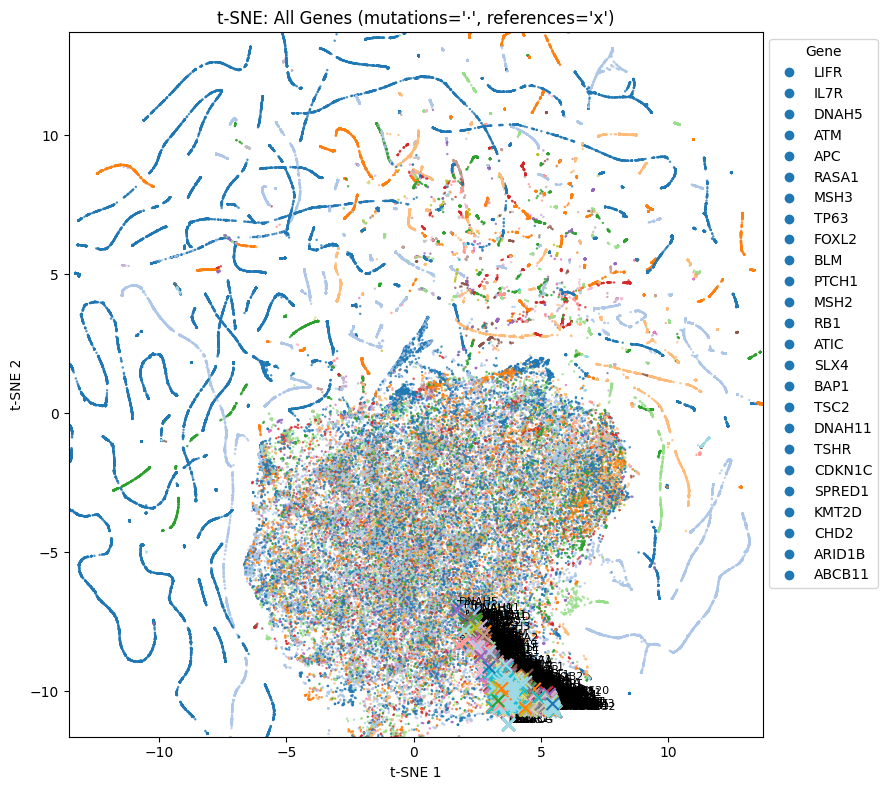

<Axes: title={'center': "t-SNE: All Genes (mutations='·', references='x')"}, xlabel='t-SNE 1', ylabel='t-SNE 2'>

In [63]:
mut_embeddings = h5py.File('/data/dandreas/MutationModel/data/training_diff_embeddings_sum_after_infonce.h5', 'r')['embeddings']
ref_embeddings = h5py.File('/data/dandreas/MutationModel/data/training_ref_embeddings_after_infonce.h5', 'r')['embeddings']
mut2ref = pickleLoad('/data/dandreas/MutationModel/data/map_mut_to_ref.pkl')
plot_all_embeddings(training_data,
    mut_embeddings = np.array(mut_embeddings),
    ref_embeddings = np.array(ref_embeddings),
    mut_to_ref_index = mut2ref,
    perplexity = 30,
    metric = "cosine",
    random_state = 42,
    figsize=(8, 8),
    show_legend = True,
    annotate_refs = True,
    zoom=True
)

/home/dandreas/.conda/envs/esm3_modernBERT/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


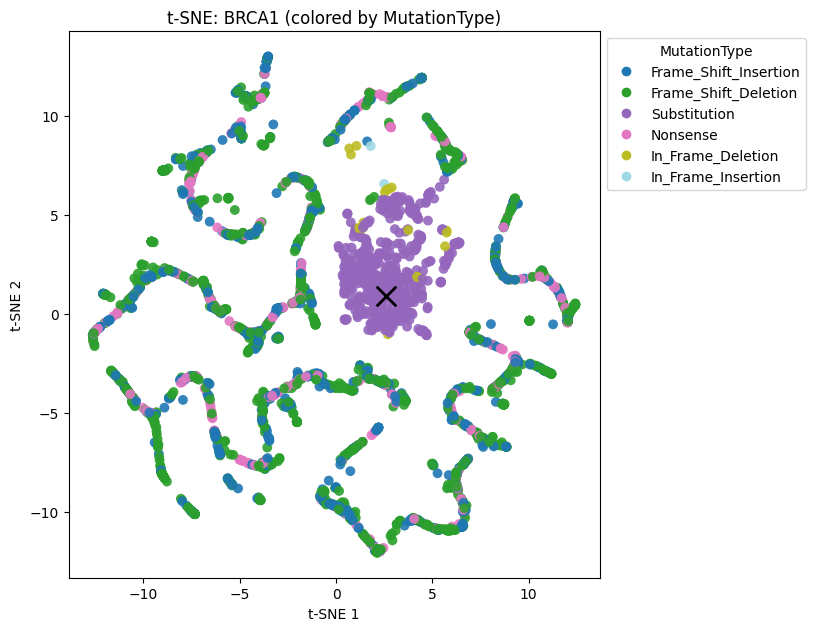

<Axes: title={'center': 't-SNE: BRCA1 (colored by MutationType)'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>

In [26]:
plot_single_gene(
    training_data,
    gene = "BRCA1",
    mut_embeddings = np.array(mut_embeddings),
    ref_embeddings = np.array(ref_embeddings),
    mut_to_ref_index = mut2ref,
    color_by = "MutationType",  # or "ClinicalSignificance"
    perplexity = None,
    metric = "cosine",
    random_state = 42,
    figsize=(6, 6),
)

/home/dandreas/.conda/envs/esm3_modernBERT/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


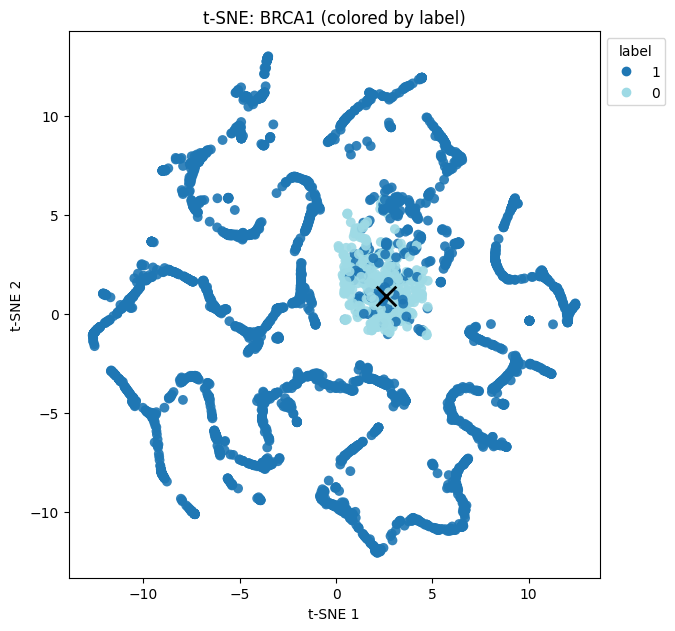

<Axes: title={'center': 't-SNE: BRCA1 (colored by label)'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>

In [25]:
plot_single_gene(
    training_data,
    gene = "BRCA1",
    mut_embeddings = np.array(mut_embeddings),
    ref_embeddings = np.array(ref_embeddings),
    mut_to_ref_index = mut2ref,
    color_by = "label",  # or "ClinicalSignificance"
    perplexity = None,
    metric = "cosine",
    random_state = 42,
    figsize=(6, 6),
)

/home/dandreas/.conda/envs/esm3_modernBERT/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


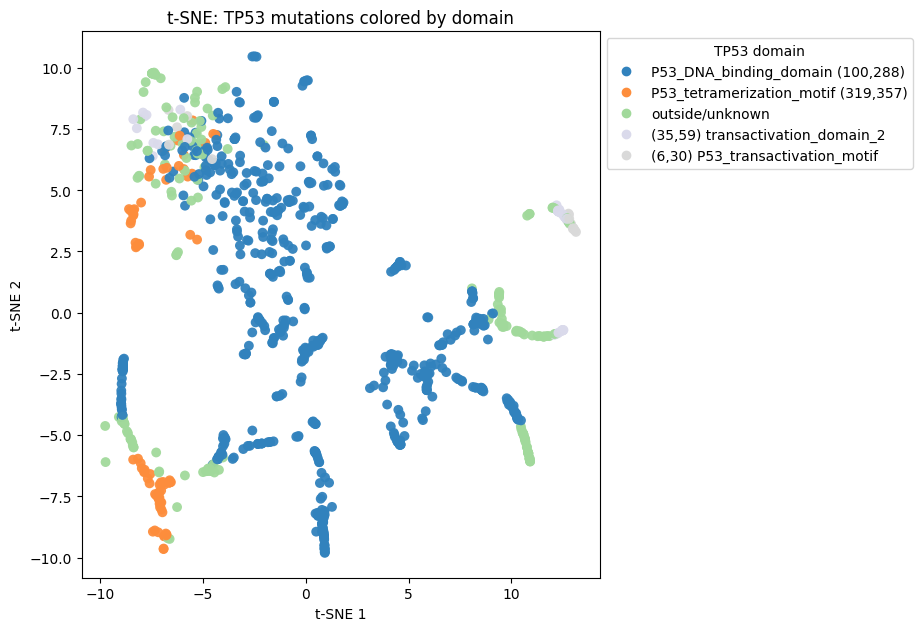

<Axes: title={'center': 't-SNE: TP53 mutations colored by domain'}, xlabel='t-SNE 1', ylabel='t-SNE 2'>

In [18]:
tp53_domains = {
                # (0,6):'(0,6)',
                (6,30):'(6,30) P53_transactivation_motif',
                # (30,35):'(30,35)', 
                (35,59):'(35,59) transactivation_domain_2',
                # (59,100):'(59,100)', 
                (100,288):'P53_DNA_binding_domain (100,288)',
                # (288,319):'(288,319)', 
                (319,357):'P53_tetramerization_motif (319,357)', 
                # (357,393):'(357,393)'
                }

plot_tp53_by_domain(
    training_data,
    mut_embeddings= np.array(mut_embeddings),
    tp53_domains=tp53_domains,
    gene_name="TP53",
    aa_col="affected_aa_start",
    perplexity=None,
    metric="cosine",
    random_state=42,
    figsize=(6, 6),
    zoom = False,
)

# Embed Somatt

,HGNC_ID,Assembly,Mutated Sequence,Reference Sequence,affected_aa_start,affected_ref_aa_end,affected_mut_aa_end,cropped mut seq,cropped ref seq,Phenotypes,ClinicalSignificance,MutationType,Levenshtein,interpro_ids,Description,DescriptionSimple,label
0,HGNC:6597,GRCh37,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,409.0,1097.0,422.0,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,Stüve-Wiedemann syndrome 1,Pathogenic,Frame_Shift_Deletion,688,"['IPR003961', 'IPR013783', 'IPR003529', 'IPR05...",loss-of-function (frameshift) in LIFR; Clinica...,loss-of-function (frameshift) in LIFR; Clinica...,1
1,HGNC:6597,GRCh37,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,540.0,1097.0,547.0,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,MMDIYVCLKRPSWMVDNKRMRTASNFQWLLSTFILLYLMNQVNSQK...,Stüve-Wiedemann syndrome 1,Pathogenic,Frame_Shift_Insertion,557,"['IPR003961', 'IPR013783', 'IPR003529', 'IPR05...",loss-of-function (frameshift) in LIFR; Clinica...,loss-of-function (frameshift) in LIFR; Clinica...,1
2,HGNC:6024,GRCh37,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,196.0,459.0,239.0,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,Immunodeficiency 104,Pathogenic,Frame_Shift_Deletion,263,"['IPR003961', 'IPR013783', 'IPR003531']",loss-of-function (frameshift) in IL7R; Clinica...,loss-of-function (frameshift) in IL7R; Clinica...,1
3,HGNC:6024,GRCh37,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,164.0,459.0,166.0,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,Immunodeficiency 104,Pathogenic,Frame_Shift_Deletion,295,"['IPR003961', 'IPR013783', 'IPR003531']",loss-of-function (frameshift) in IL7R; Clinica...,loss-of-function (frameshift) in IL7R; Clinica...,1
4,HGNC:6024,GRCh37,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,58.0,459.0,79.0,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,MTILGTTFGMVFSLLQVVSGESGYAQNGDLEDAELDDYSFSCYSQL...,Immunodeficiency 104,Pathogenic,Frame_Shift_Deletion,401,"['IPR003961', 'IPR040997', 'IPR013783', 'IPR00...",loss-of-function (frameshift) in IL7R; Clinica...,loss-of-function (frameshift) in IL7R; Clinica...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114498,HGNC:4932,GRCh38,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,122.0,123.0,123.0,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,MLVMAPRTVLLLLSAALALTETWAGSHSMRYFYTSVSRPGRGEPRF...,NaN,Likely benign,Substitution,1,"['IPR050208', 'IPR001039', 'IPR011161', 'IPR01...",substitution (small; 1 aa) in HLA-B; Clinical ...,substitution (small; 1 aa) in HLA-B; Clinical ...,0
114499,HGNC:44,GRCh38,MRLPDLRPWTSLLLVDAALLWLLQGPLGTLLPQGLPGLWLEGTLRL...,MRLPDLRPWTSLLLVDAALLWLLQGPLGTLLPQGLPGLWLEGTLRL...,59.0,686.0,59.0,MRLPDLRPWTSLLLVDAALLWLLQGPLGTLLPQGLPGLWLEGTLRL...,MRLPDLRPWTSLLLVDAALLWLLQGPLGTLLPQGLPGLWLEGTLRL...,MHC class I deficiency,Pathogenic,Nonsense,627,"['IPR003593', 'IPR013305', 'IPR011527', 'IPR03...",loss-of-function (premature stop) in TAP2; Cli...,loss-of-function (premature stop) in TAP2; Cli...,1
114500,HGNC:4170,GRCh38,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,52.0,53.0,53.0,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,MEFPGLGSLGTSEPLPQFVDPALVSSTPESGVFFPSGPEGLDAAAS...,GATA binding protein 1 related thrombocytopeni...,Benign,Substitution,1,['IPR039355'],substitution (small; 1 aa) in GATA1; Clinical ...,substitution (small; 1 aa) in GATA1; Clinical ...,0
114501,HGNC:10295,GRCh38,MREPEELMPDSGAVFTFGKSKFAENNPGKFWFKNDVPVHLSCGDEH...,MREPEELMPDSGAVFTFGKSKFAENNPGKFWFKNDVPVHLSCGDEH...,828.0,1020.0,832.0,MREPEE

In [12]:
# somatt_diff = h5py.File('/data/dandreas/SomaticMutationsLLM/aa/canonical_mut_sum_diff_embeddings_esm2.h5', 'r')['embeddings']
# out_path = '/data/dandreas/MutationModel/data/somatt_diff_embeddings_sum.h5'
embs = sequence_embeddings = h5py.File('/data/dandreas/MutationModel/data/training_reference_embeddings.h5', 'r')['embeddings'][:]
out_path = '/data/dandreas/MutationModel/data/training_ref_embeddings_after_infonce.h5'
output_dim = 256
emb_dim = 640 

class SimpleDataset(Dataset):
    def __init__(
        self,
        emb
    ):
        self.emb = emb

    def __len__(self):
        return len(self.emb)

    def __getitem__(self, i):
        return {
            "seq": {'emb': self.emb[i].reshape(-1, 640)[0]},
        }
dataset = SimpleDataset(embs)
dataloader = DataLoader(
    dataset,
    batch_size=1000,
    shuffle=False,
    num_workers=0, 
    pin_memory=True)

if os.path.exists(out_path):
    print(f'\tremoved {out_path}')
    os.remove(out_path)

#CREATE OUTPUT HDF5 FILE
h5f = h5py.File(out_path, 'a')
embeddings = h5f.create_dataset(
    'embeddings',
    shape=(len(embs), output_dim),
    dtype=np.dtype('float32'),
    chunks=(dataloader.batch_size,output_dim)
)
print(f'\t\t{out_path} created with shape {embeddings.shape}')

offset = 0
for step, batch in enumerate(tqdm(dataloader)):
    batch = to_device(batch, config.device)
    with torch.no_grad():
        emb = model(batch, seq_emb_only=True).detach().cpu().numpy()
    n = emb.shape[0]
    embeddings[offset: offset+n, :] = emb
    offset += n

h5f.close()

		/data/dandreas/MutationModel/data/training_ref_embeddings_after_infonce.h5 created with shape (1263, 256)


100%|██████████| 2/2 [00:00<00:00, 100.22it/s]


# Tests

In [ ]:
config = Config_InfoNCE()
model = InfoNCE(config)
one = x[0]
one['text'] = {k: v.unsqueeze(0).to(config.device) for k,v in one['text'].items()}
one['seq']  = {k: v.unsqueeze(0).to(config.device) for k,v in one['seq'].items()}
loss, acc = model(one['text'], one['seq'])
loss, acc

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


text emb torch.Size([1, 768])
seq emb torch.Size([1, 640])


(tensor(0., device='cuda:1', grad_fn=<DivBackward0>), 1.0)

In [ ]:
from torch.utils.data import DataLoader

collate = TokenizedPairCollator(x.text_tokenizer, x.plm_tokenizer)
loader  = DataLoader(x, batch_size=8, shuffle=True, num_workers=4,
                     pin_memory=True, collate_fn=collate, persistent_workers=True)

for batch in loader:
    text = {k: v.to(config.device, non_blocking=True) for k,v in batch['text'].items()}
    seq  = {k: v.to(config.device, non_blocking=True) for k,v in batch['seq'].items()}
    loss, acc = model(text, seq)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
You're using a PreTrainedTok

text emb torch.Size([2, 768])
seq emb torch.Size([2, 640])


In [ ]:
import torch

@torch.no_grad()
def cls_text(model, tok_dict):
    model.text_model.eval()
    out = model.text_model(**tok_dict).last_hidden_state  # [B, L, H]
    return out[:, 0, :].float()                           # [B, H]

@torch.no_grad()
def cls_esm2(model, tok_dict):
    model.plm_model.eval()
    out = model.plm_model(**tok_dict).last_hidden_state   # [B, L, D]
    return out[:, 0, :].float()                           # [B, D]

def report_diff(a, b, name, atol=1e-5, rtol=1e-4):
    a = a.squeeze(0).float().cpu()
    b = b.squeeze(0).float().cpu()
    diff = (a - b)
    print(f"[{name}]  L2={diff.norm().item():.6g}   max|Δ|={diff.abs().max().item():.6g}   cos={torch.nn.functional.cosine_similarity(a,b,dim=0).item():.6f}")
    print(f"[{name}]  allclose: {torch.allclose(a, b, atol=atol, rtol=rtol)}")


In [ ]:
cfg = Config_InfoNCE()
model = InfoNCE(cfg)

text_tok = AutoTokenizer.from_pretrained(cfg.text_model)

# One short and one much longer text to force padding of the short one in the batch
t_short = "This is TP53."
t_long  = " ".join(["This is KRAS."] * 200)

# No-padding (batch of 1)
solo = text_tok([t_short], return_tensors="pt", padding=False, truncation=True)
solo = {k: v.to(cfg.device) for k, v in solo.items()}
e_solo = cls_text(model, solo)  # [1, H]

# Padded batch (short + long)
batch = text_tok([t_short, t_long], return_tensors="pt", padding=True, truncation=True)
batch = {k: v.to(cfg.device) for k, v in batch.items()}
e_batch = cls_text(model, batch)[0:1]  # take first row → same sample

report_diff(e_solo, e_batch, "TEXT-CLS")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[TEXT-CLS]  L2=0.377113   max|Δ|=0.125   cos=0.999945
[TEXT-CLS]  allclose: False


In [ ]:
esm_name = "facebook/esm2_t30_150M_UR50D"
seq_tok  = AutoTokenizer.from_pretrained(esm_name)

s_short = "MEASE"
s_long  = "M" + "E"*800 + "K"  # long to force padding (still under default max length)

# No-padding (batch of 1)
solo = seq_tok([s_short], return_tensors="pt", padding=False, truncation=True)
solo = {k: v.to(cfg.device) for k, v in solo.items()}
z_solo = cls_esm2(model, solo)  # [1, D]

# Padded batch
batch = seq_tok([s_short, s_long], return_tensors="pt", padding=True, truncation=True)
batch = {k: v.to(cfg.device) for k, v in batch.items()}
z_batch = cls_esm2(model, batch)[0:1]

report_diff(z_solo, z_batch, "ESM2-CLS")


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[ESM2-CLS]  L2=7.71947e-06   max|Δ|=1.90735e-06   cos=1.000000
[ESM2-CLS]  allclose: True


In [ ]:
@torch.no_grad()
def project_text(model, tok):  # [1,E]
    model.eval()
    x = cls_text(model, tok).to(model.text2latent.weight.dtype)
    return model.text2latent(x).float()

@torch.no_grad()
def project_esm2(model, tok):  # [1,E]
    model.eval()
    x = cls_esm2(model, tok).to(model.seq2latent.weight.dtype)
    return model.seq2latent(x).float()

# Reuse solo/batch dicts from above
report_diff(project_text(model, solo),  project_text(model, batch | {"input_ids": batch["input_ids"][0:1], "attention_mask": batch["attention_mask"][0:1]}), "TEXT-proj")  # solo vs (just first row)
report_diff(project_esm2(model, solo), project_esm2(model, batch | {"input_ids": batch["input_ids"][0:1], "attention_mask": batch["attention_mask"][0:1]}), "ESM2-proj")


[TEXT-proj]  L2=0   max|Δ|=0   cos=1.000000
[TEXT-proj]  allclose: True
[ESM2-proj]  L2=2.68589e-06   max|Δ|=5.06639e-07   cos=1.000000
[ESM2-proj]  allclose: True


In [ ]:
@torch.no_grad()
def cls_text(model, tok):
    model.text_model.eval()
    return model.text_model(**tok).last_hidden_state[:, 0, :].float()

def pad_invariance_test_text(model, tokenizer, s_short, s_long, device="cuda:0"):
    # Make a padded batch [short, long]
    batch = tokenizer([s_short, s_long], return_tensors="pt", padding=True, truncation=True)
    batch = {k: v.to(device) for k,v in batch.items()}
    e1 = cls_text(model, batch)[0:1]  # CLS for the short sample

    # Mutate the PAD positions in the short sample (keep attention_mask == 0)
    pad_id = tokenizer.pad_token_id
    rand_ids = torch.randint(low=0, high=tokenizer.vocab_size, size=batch["input_ids"][0].shape, device=device)
    is_pad = (batch["attention_mask"][0] == 0)
    batch2 = {k: v.clone() for k,v in batch.items()}
    batch2["input_ids"][0][is_pad] = rand_ids[is_pad]  # change only pad slots
    e2 = cls_text(model, batch2)[0:1]

    diff = (e1 - e2).norm().item()
    print(f"[TEXT pad-invariance] ||Δ|| = {diff:.6g}, cos = {torch.nn.functional.cosine_similarity(e1,e2,dim=1).item():.6f}")
    return e1, e2

# ESM2 variant
@torch.no_grad()
def cls_esm2(model, tok):
    model.plm_model.eval()
    return model.plm_model(**tok).last_hidden_state[:, 0, :].float()

def pad_invariance_test_esm2(model, tokenizer, s_short, s_long, device="cuda:0"):
    batch = tokenizer([s_short, s_long], return_tensors="pt", padding=True, truncation=True)
    batch = {k: v.to(device) for k,v in batch.items()}
    z1 = cls_esm2(model, batch)[0:1]

    pad_id = tokenizer.pad_token_id
    rand_ids = torch.randint(low=0, high=tokenizer.vocab_size, size=batch["input_ids"][0].shape, device=device)
    is_pad = (batch["attention_mask"][0] == 0)
    batch2 = {k: v.clone() for k,v in batch.items()}
    batch2["input_ids"][0][is_pad] = rand_ids[is_pad]
    z2 = cls_esm2(model, batch2)[0:1]

    diff = (z1 - z2).norm().item()
    print(f"[ESM2 pad-invariance] ||Δ|| = {diff:.6g}, cos = {torch.nn.functional.cosine_similarity(z1,z2,dim=1).item():.6f}")
    return z1, z2


In [ ]:
def text_cls_compare_fp32_eager(model, tokenizer, s_short, s_long, device="cuda:0"):
    # Temporarily cast model to fp32 and swap attention impl
    orig_dtype = next(model.text_model.parameters()).dtype
    orig_impl  = getattr(model.text_model.config, "attn_implementation", None)
    model.text_model.to(torch.float32)
    try:
        model.text_model.config.attn_implementation = "eager"
    except Exception:
        pass

    with torch.no_grad():
        solo = tokenizer([s_short], return_tensors="pt", padding=False, truncation=True)
        solo = {k: v.to(device) for k,v in solo.items()}
        e_solo = model.text_model(**solo).last_hidden_state[:,0,:].float()

        batch = tokenizer([s_short, s_long], return_tensors="pt", padding=True, truncation=True)
        batch = {k: v.to(device) for k,v in batch.items()}
        e_batch = model.text_model(**batch).last_hidden_state[:,0,:].float()[0:1]

    # Restore dtype/impl
    model.text_model.to(orig_dtype)
    try:
        model.text_model.config.attn_implementation = orig_impl
    except Exception:
    # some configs don’t allow setting back; harmless
        pass

    diff = (e_solo - e_batch).norm().item()
    print(f"[TEXT fp32-eager] ||Δ|| = {diff:.6g}, cos = {torch.nn.functional.cosine_similarity(e_solo,e_batch,dim=1).item():.6f}")
    return e_solo, e_batch


In [ ]:
@torch.no_grad()
def project_text(model, tok):
    x = model.text_model(**tok).last_hidden_state[:,0,:]
    x = x.to(model.text2latent.weight.dtype)
    return model.text2latent(x).float()

def compare_text_projected(model, tokenizer, s_short, s_long, device="cuda:0"):
    solo = tokenizer([s_short], return_tensors="pt", padding=False, truncation=True)
    solo = {k: v.to(device) for k,v in solo.items()}
    e1 = project_text(model, solo)

    batch = tokenizer([s_short, s_long], return_tensors="pt", padding=True, truncation=True)
    batch = {k: v.to(device) for k,v in batch.items()}
    e2 = project_text(model, {k: v[:1] for k,v in batch.items()})  # take first row cleanly

    d = (e1 - e2).norm().item()
    print(f"[TEXT-proj check] ||Δ|| = {d:.6g}, cos = {torch.nn.functional.cosine_similarity(e1,e2,dim=1).item():.6f}")


In [ ]:
# ===== Padding invariance tests for ModernBERT (text) and ESM2 (sequence) =====
import torch
from transformers import AutoTokenizer
# Assumes your InfoNCE + Config_InfoNCE classes are already defined/imported

# ------------------ Build model & tokenizers ------------------
cfg = Config_InfoNCE()
device = cfg.device
model = InfoNCE(cfg).eval()

text_tok = AutoTokenizer.from_pretrained(cfg.text_model)
seq_tok  = AutoTokenizer.from_pretrained("facebook/esm2_t30_150M_UR50D")

# Choose pairs that force padding for the first item in the batch
t_short = "This is TP53."
t_long  = " ".join(["This is KRAS."] * 200)

s_short = "MEASE"
s_long  = "M" + "E"*800 + "K"  # long enough to cause padding for the short sample


# ------------------ Helpers ------------------
@torch.no_grad()
def cls_text(model, tok_dict):
    out = model.text_model(**tok_dict).last_hidden_state  # [B, L, H]
    return out[:, 0, :].float()

@torch.no_grad()
def cls_esm2(model, tok_dict):
    out = model.plm_model(**tok_dict).last_hidden_state   # [B, L, D]
    return out[:, 0, :].float()

def report_diff(a, b, name, atol=1e-5, rtol=1e-4):
    a = a.squeeze(0).float().cpu()
    b = b.squeeze(0).float().cpu()
    diff = (a - b)
    cos  = torch.nn.functional.cosine_similarity(a, b, dim=0).item()
    print(f"[{name}]  L2={diff.norm().item():.6g}   max|Δ|={diff.abs().max().item():.6g}   cos={cos:.6f}")
    print(f"[{name}]  allclose: {torch.allclose(a, b, atol=atol, rtol=rtol)}")

def to_device(d, device):
    return {k: v.to(device) for k, v in d.items()}

# ------------------ Test 1: CLS with/without padding ------------------
with torch.no_grad():
    # TEXT
    solo_t  = to_device(text_tok([t_short], return_tensors="pt", padding=False, truncation=True), device)
    batch_t = to_device(text_tok([t_short, t_long], return_tensors="pt", padding=True, truncation=True), device)
    e_solo  = cls_text(model, solo_t)          # [1, H]
    e_batch = cls_text(model, batch_t)[0:1]    # first row corresponds to short sample
    report_diff(e_solo, e_batch, "TEXT-CLS")

    # ESM2
    solo_s  = to_device(seq_tok([s_short], return_tensors="pt", padding=False, truncation=True), device)
    batch_s = to_device(seq_tok([s_short, s_long], return_tensors="pt", padding=True, truncation=True), device)
    z_solo  = cls_esm2(model, solo_s)          # [1, D]
    z_batch = cls_esm2(model, batch_s)[0:1]
    report_diff(z_solo, z_batch, "ESM2-CLS")

# ------------------ Test 2: Pad-token invariance (mutate PAD ids, mask stays 0) ------------------
@torch.no_grad()
def pad_invariance_text():
    batch = to_device(text_tok([t_short, t_long], return_tensors="pt", padding=True, truncation=True), device)
    e1 = cls_text(model, batch)[0:1]
    rand_ids = torch.randint(0, text_tok.vocab_size, batch["input_ids"][0].shape, device=device)
    is_pad = (batch["attention_mask"][0] == 0)
    batch2 = {k: v.clone() for k,v in batch.items()}
    batch2["input_ids"][0][is_pad] = rand_ids[is_pad]  # change only pads
    e2 = cls_text(model, batch2)[0:1]
    report_diff(e1, e2, "TEXT pad-invariance")

@torch.no_grad()
def pad_invariance_esm2():
    batch = to_device(seq_tok([s_short, s_long], return_tensors="pt", padding=True, truncation=True), device)
    z1 = cls_esm2(model, batch)[0:1]
    rand_ids = torch.randint(0, seq_tok.vocab_size, batch["input_ids"][0].shape, device=device)
    is_pad = (batch["attention_mask"][0] == 0)
    batch2 = {k: v.clone() for k,v in batch.items()}
    batch2["input_ids"][0][is_pad] = rand_ids[is_pad]
    z2 = cls_esm2(model, batch2)[0:1]
    report_diff(z1, z2, "ESM2 pad-invariance")

pad_invariance_text()
pad_invariance_esm2()

# ------------------ Test 3: TEXT under fp32 + eager attention (remove bf16/flash noise) ------------------
def text_cls_compare_fp32_eager():
    # Save original dtype/impl
    orig_dtype = next(model.text_model.parameters()).dtype
    orig_impl  = getattr(model.text_model.config, "attn_implementation", None)

    # Switch to fp32 + eager
    model.text_model.to(torch.float32)
    try:
        model.text_model.config.attn_implementation = "eager"
    except Exception:
        pass

    with torch.no_grad():
        solo  = to_device(text_tok([t_short], return_tensors="pt", padding=False, truncation=True), device)
        batch = to_device(text_tok([t_short, t_long], return_tensors="pt", padding=True, truncation=True), device)
        e_solo  = model.text_model(**solo).last_hidden_state[:,0,:].float()
        e_batch = model.text_model(**batch).last_hidden_state[:,0,:].float()[0:1]
        report_diff(e_solo, e_batch, "TEXT-CLS fp32-eager")

    # Restore
    model.text_model.to(orig_dtype)
    try:
        model.text_model.config.attn_implementation = orig_impl
    except Exception:
        pass

text_cls_compare_fp32_eager()

# ------------------ Test 4 (optional): compare AFTER projection layers ------------------
@torch.no_grad()
def project_text(model, tok):
    x = model.text_model(**tok).last_hidden_state[:,0,:]
    x = x.to(model.text2latent.weight.dtype)
    return model.text2latent(x).float()

@torch.no_grad()
def project_esm2(model, tok):
    x = model.plm_model(**tok).last_hidden_state[:,0,:]
    x = x.to(model.seq2latent.weight.dtype)
    return model.seq2latent(x).float()

with torch.no_grad():
    # TEXT projected
    e1 = project_text(model, to_device(text_tok([t_short], return_tensors="pt", padding=False, truncation=True), device))
    b  = to_device(text_tok([t_short, t_long], return_tensors="pt", padding=True, truncation=True), device)
    e2 = project_text(model, b)[0:1]
    report_diff(e1, e2, "TEXT-proj")

    # ESM2 projected
    s1 = project_esm2(model, to_device(seq_tok([s_short], return_tensors="pt", padding=False, truncation=True), device))
    bb = to_device(seq_tok([s_short, s_long], return_tensors="pt", padding=True, truncation=True), device)
    s2 = project_esm2(model, bb)[0:1]
    report_diff(s1, s2, "ESM2-proj")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[TEXT-CLS]  L2=0.377113   max|Δ|=0.125   cos=0.999945
[TEXT-CLS]  allclose: False
[ESM2-CLS]  L2=7.71947e-06   max|Δ|=1.90735e-06   cos=1.000000
[ESM2-CLS]  allclose: True
[TEXT pad-invariance]  L2=0   max|Δ|=0   cos=1.000000
[TEXT pad-invariance]  allclose: True
[ESM2 pad-invariance]  L2=11.8906   max|Δ|=7.62421   cos=-0.003957
[ESM2 pad-invariance]  allclose: False
[TEXT-CLS fp32-eager]  L2=0.0813949   max|Δ|=0.0114362   cos=0.999997
[TEXT-CLS fp32-eager]  allclose: False
[TEXT-proj]  L2=0.135376   max|Δ|=0.0238476   cos=0.999927
[TEXT-proj]  allclose: False
[ESM2-proj]  L2=3.11636e-06   max|Δ|=6.25849e-07   cos=1.000000
[ESM2-proj]  allclose: True


# BioClinical ModernBERT

In [ ]:
### EXAMPLE USAGE

#Hidden states
model_id = "thomas-sounack/BioClinical-ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id,
                                             attn_implementation="flash_attention_2",
                                             torch_dtype=torch.bfloat16,
                                             reference_compile=False)
model.to("cuda:1")
text = "Mitochondria is the powerhouse of the [MASK]."
inputs = tokenizer(text, return_tensors="pt").to("cuda:1")
outputs = model(**inputs)
print(dir(outputs))
print(outputs.last_hidden_state.shape)


#LM Head
model = AutoModelForMaskedLM.from_pretrained(model_id,
                                             attn_implementation="flash_attention_2",
                                             torch_dtype=torch.bfloat16,
                                             reference_compile=False)
model.to("cuda:1")
outputs = model(**inputs)
masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
predicted_token = tokenizer.decode(predicted_token_id)
print("Predicted token:", predicted_token)

['__annotations__', '__class__', '__class_getitem__', '__contains__', '__dataclass_fields__', '__dataclass_params__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__ior__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__ne__', '__new__', '__or__', '__post_init__', '__reduce__', '__reduce_ex__', '__repr__', '__reversed__', '__ror__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', 'attentions', 'clear', 'copy', 'fromkeys', 'get', 'hidden_states', 'items', 'keys', 'last_hidden_state', 'move_to_end', 'pop', 'popitem', 'setdefault', 'to_tuple', 'update', 'values']
torch.Size([1, 13, 768])
Predicted token:  cell


{'input_ids': tensor([[50281, 34967,  9217,  5182,   310,   253,  1612,  5967,   273,   253,
         50284,    15, 50282]], device='cuda:1'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:1')}

# LLAMA

In [ ]:
model_name = "aaditya/OpenBioLLM-Llama3-8B"
device = 'cuda:0'

base_lm = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map=device
)

tokenizer = AutoTokenizer.from_pretrained(model_name,use_fast=True)

base_lm.to(device)

/home/dandreas/.conda/envs/esm3_peft/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

In [ ]:
class LlamaMutationConfig:
    chat_template: str = "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = \"26 Jul 2024\" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- \"Tools: \" + builtin_tools | reject('equalto', 'code_interpreter') | join(\", \") + \"\\n\\n\"}}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- \"<|python_tag|>\" + tool_call.name + \".call(\" }}\n            {%- for arg_name, arg_val in tool_call.arguments | items %}\n                {{- arg_name + '=\"' + arg_val + '\"' }}\n                {%- if not loop.last %}\n                    {{- \", \" }}\n                {%- endif %}\n                {%- endfor %}\n            {{- \")\" }}\n        {%- else  %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n            {{- '\"parameters\": ' }}\n            {{- tool_call.arguments | tojson }}\n            {{- \"}\" }}\n        {%- endif %}\n        {%- if builtin_tools is defined %}\n            {#- This means we're in ipython mode #}\n            {{- \"<|eom_id|>\" }}\n        {%- else %}\n            {{- \"<|eot_id|>\" }}\n        {%- endif %}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n"
    model_name: str = 'aaditya/OpenBioLLM-Llama3-8B'
    system_prompt: str = 'You are an expert in genomics and proteomics. Respond clearly and concisely.'
    device: str = 'cuda:2'

class LlamaMutation(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(config.model_name, torch_dtype=torch.bfloat16, device_map=config.device)
        self.tokenizer = AutoTokenizer.from_pretrained(config.model_name, use_fast=True)
        self.tokenizer.chat_template = config.chat_template
        self.system_prompt = config.system_prompt
        self._init_tokenizer()

    def _init_tokenizer(self):
        self.protein_start_token, self.protein_emb_token, self.protein_end_token = "<protein>", "<protein_emb>", "</protein>"
        special_tokens = [self.protein_start_token, self.protein_emb_token, self.protein_end_token]
        self.tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
        self.protein_start_id, self.protein_emb_id, self.protein_end_id = (self.tokenizer.convert_tokens_to_ids(i) for i in special_tokens)
        special_token_ids = [self.protein_start_id, self.protein_emb_id, self.protein_end_id]
        self.model.resize_token_embeddings(len(self.tokenizer))
        for i in special_token_ids:
            self._init_token_embedding(i)

    def _init_token_embedding(self, token_id):
        embed_layer = self.model.get_input_embeddings()
        hidden_size = embed_layer.weight.shape[1]
        if token_id < embed_layer.weight.shape[0]:
            nn.init.xavier_uniform_(embed_layer.weight.data[token_id].view(1, hidden_size))
        else:
            print(f"[WARNING] WT protein start token ID {token_id} is out of bounds for embedding layer")

    def create_message(self, a):
        prompt = [
            {'role': 'system', 'content': (self.system_prompt)},
            {'role': 'user', 'content': '<protein> <protein_emb> </protein>'},
            {'role': 'assistant', 'content': a}
        ]
        if a is None: 
            prompt = prompt[:-1]
            add_gen = True
        else:
            add_gen = False
        prompt = self.tokenizer.apply_chat_template(prompt, tokenize=True, add_generation_prompt=add_gen)
        prompt = torch.tensor(prompt, dtype=torch.long, device=self.model.device)
        prompt = self.model.get_input_embeddings()(prompt)
        return prompt
    
    #project to 1496
    def forward(self, x):
        q_emb, a = x
        
        # return self.model.forward(
        #     input_ids=fwd_input_ids,
        #     attention_mask=fwd_attention_mask,
        #     position_ids=position_ids,
        #     past_key_values=past_key_values,
        #     inputs_embeds=fwd_inputs_embeds,
        #     labels=fwd_labels,
        #     use_cache=use_cache,
        #     output_attentions=output_attentions,
        #     output_hidden_states=output_hidden_states,
        #     return_dict=return_dict,
        # )

config = LlamaMutationConfig()
lm = LlamaMutation(config)

prompt = lm.create_message(None)
print('--------prompt--------')
print(prompt.shape)
print(prompt)

/home/dandreas/.conda/envs/esm3_peft/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.06s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


--------prompt--------
torch.Size([58, 4096])
tensor([[-1.4305e-04,  1.0777e-04, -1.9646e-04,  ...,  2.0218e-04,
          1.4842e-05,  3.0136e-04],
        [-1.6337e-23,  3.9033e-24, -2.0473e-23,  ..., -2.6883e-23,
         -3.0399e-23,  9.4092e-24],
        [ 5.3406e-03,  1.5869e-03, -3.8300e-03,  ..., -1.7262e-04,
          5.7068e-03,  1.3550e-02],
        ...,
        [-8.8501e-03, -2.9602e-03,  4.8523e-03,  ...,  2.8229e-04,
         -1.3046e-03,  8.1787e-03],
        [ 2.5746e-23,  3.2958e-25, -4.4202e-24,  ...,  1.3338e-23,
          7.9099e-24,  8.4269e-24],
        [-2.6398e-03,  4.0894e-03, -4.8280e-06,  ...,  1.6937e-03,
         -9.3079e-04,  1.6479e-03]], device='cuda:2', dtype=torch.bfloat16,
       grad_fn=<EmbeddingBackward0>)


In [ ]:
create_message = lambda q, a: [
    {'role': 'system','content': ('You are an expert in genomics and proteomics. Respond clearly and concisely.')},
    {'role': 'user', 'content': f'{q}'},
    # {'role': 'assistant', 'content': f'{a}'} 
    ]

q = create_message("Describe the TADII motif in tp53.", "Example Response")

llama3_template = "{{- bos_token }}\n{%- if custom_tools is defined %}\n    {%- set tools = custom_tools %}\n{%- endif %}\n{%- if not tools_in_user_message is defined %}\n    {%- set tools_in_user_message = true %}\n{%- endif %}\n{%- if not date_string is defined %}\n    {%- set date_string = \"26 Jul 2024\" %}\n{%- endif %}\n{%- if not tools is defined %}\n    {%- set tools = none %}\n{%- endif %}\n\n{#- This block extracts the system message, so we can slot it into the right place. #}\n{%- if messages[0]['role'] == 'system' %}\n    {%- set system_message = messages[0]['content']|trim %}\n    {%- set messages = messages[1:] %}\n{%- else %}\n    {%- set system_message = \"\" %}\n{%- endif %}\n\n{#- System message + builtin tools #}\n{{- \"<|start_header_id|>system<|end_header_id|>\\n\\n\" }}\n{%- if builtin_tools is defined or tools is not none %}\n    {{- \"Environment: ipython\\n\" }}\n{%- endif %}\n{%- if builtin_tools is defined %}\n    {{- \"Tools: \" + builtin_tools | reject('equalto', 'code_interpreter') | join(\", \") + \"\\n\\n\"}}\n{%- endif %}\n{{- \"Cutting Knowledge Date: December 2023\\n\" }}\n{{- \"Today Date: \" + date_string + \"\\n\\n\" }}\n{%- if tools is not none and not tools_in_user_message %}\n    {{- \"You have access to the following functions. To call a function, please respond with JSON for a function call.\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n{%- endif %}\n{{- system_message }}\n{{- \"<|eot_id|>\" }}\n\n{#- Custom tools are passed in a user message with some extra guidance #}\n{%- if tools_in_user_message and not tools is none %}\n    {#- Extract the first user message so we can plug it in here #}\n    {%- if messages | length != 0 %}\n        {%- set first_user_message = messages[0]['content']|trim %}\n        {%- set messages = messages[1:] %}\n    {%- else %}\n        {{- raise_exception(\"Cannot put tools in the first user message when there's no first user message!\") }}\n{%- endif %}\n    {{- '<|start_header_id|>user<|end_header_id|>\\n\\n' -}}\n    {{- \"Given the following functions, please respond with a JSON for a function call \" }}\n    {{- \"with its proper arguments that best answers the given prompt.\\n\\n\" }}\n    {{- 'Respond in the format {\"name\": function name, \"parameters\": dictionary of argument name and its value}.' }}\n    {{- \"Do not use variables.\\n\\n\" }}\n    {%- for t in tools %}\n        {{- t | tojson(indent=4) }}\n        {{- \"\\n\\n\" }}\n    {%- endfor %}\n    {{- first_user_message + \"<|eot_id|>\"}}\n{%- endif %}\n\n{%- for message in messages %}\n    {%- if not (message.role == 'ipython' or message.role == 'tool' or 'tool_calls' in message) %}\n        {{- '<|start_header_id|>' + message['role'] + '<|end_header_id|>\\n\\n'+ message['content'] | trim + '<|eot_id|>' }}\n    {%- elif 'tool_calls' in message %}\n        {%- if not message.tool_calls|length == 1 %}\n            {{- raise_exception(\"This model only supports single tool-calls at once!\") }}\n        {%- endif %}\n        {%- set tool_call = message.tool_calls[0].function %}\n        {%- if builtin_tools is defined and tool_call.name in builtin_tools %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- \"<|python_tag|>\" + tool_call.name + \".call(\" }}\n            {%- for arg_name, arg_val in tool_call.arguments | items %}\n                {{- arg_name + '=\"' + arg_val + '\"' }}\n                {%- if not loop.last %}\n                    {{- \", \" }}\n                {%- endif %}\n                {%- endfor %}\n            {{- \")\" }}\n        {%- else  %}\n            {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' -}}\n            {{- '{\"name\": \"' + tool_call.name + '\", ' }}\n            {{- '\"parameters\": ' }}\n            {{- tool_call.arguments | tojson }}\n            {{- \"}\" }}\n        {%- endif %}\n        {%- if builtin_tools is defined %}\n            {#- This means we're in ipython mode #}\n            {{- \"<|eom_id|>\" }}\n        {%- else %}\n            {{- \"<|eot_id|>\" }}\n        {%- endif %}\n    {%- elif message.role == \"tool\" or message.role == \"ipython\" %}\n        {{- \"<|start_header_id|>ipython<|end_header_id|>\\n\\n\" }}\n        {%- if message.content is mapping or message.content is iterable %}\n            {{- message.content | tojson }}\n        {%- else %}\n            {{- message.content }}\n        {%- endif %}\n        {{- \"<|eot_id|>\" }}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|start_header_id|>assistant<|end_header_id|>\\n\\n' }}\n{%- endif %}\n"

# llama3_template = """<|begin_of_text|>{% for message in messages %}
# <|start_header_id|>{{ message['role'] }}<|end_header_id|>
# {{ message['content'] }}<|eot_id|>
# {% endfor %}{% if add_generation_prompt %}
# <|start_header_id|>assistant<|end_header_id|>
# {% endif %}"""

tokenizer.chat_template = llama3_template
prompt = tokenizer.apply_chat_template(q, tokenize=False, add_generation_prompt=True)
print('--------prompt--------')
print(prompt)
print('--------output--------')
tokenized = tokenizer(prompt, return_tensors="pt").to(device)
terminators = [tokenizer.eos_token_id, tokenizer.convert_tokens_to_ids("<|eot_id|>")]
with torch.no_grad():
    outputs = base_lm.generate(**tokenized,
                               num_beams = 1,
                               do_sample = False,
                               repetition_penalty = 1.2,
                               eos_token_id = terminators,
                                pad_token_id = tokenizer.pad_token_id,
                               max_new_tokens = 1000)  
output_text = tokenizer.decode(outputs[0], skip_special_tokens=False)
print(output_text)
print('\n--------response only--------')
print(output_text.split('\n')[-1])

--------prompt--------
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert in genomics and proteomics. Respond clearly and concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

Describe the TADII motif in tp53.<|eot_id|><|start_header_id|>assistant<|end_header_id|>


--------output--------
<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are an expert in genomics and proteomics. Respond clearly and concisely.<|eot_id|><|start_header_id|>user<|end_header_id|>

Describe the TADII motif in tp53.<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The TADII motif in p53 is a transcriptional activation domain that enhances gene expression by interacting with co-activators such as CBP or P300, which can bind to acetylated histones on DNA. This interaction facilitates chromatin remodeling and allows for increased b

In [ ]:
outputs[0]

tensor([128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
            25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
           220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
           459,   6335,    304,   4173,  24203,    323,   5541,  24203,     13,
         40633,   9539,    323,   3613,    285,    989,     13, 128009, 128006,
           882, 128007,    271,  75885,    682,  13128,  31576,    315,    350,
            79,   4331,     13, 128009, 128006,  78191, 128007,    271,    791,
           281,   4331,  15207,   3289,   2601,    369,    279,  36254,  28321,
           269,  13128,  30170,   4331,     11,    902,    374,   6532,    304,
         58499,   2849,  13096,    323,  27252,   9572,  18488,    555,  96811,
         15922,  13023,    477,  95874,    994,   5995,     13,    578,   6070,
           315,  30170,   4331,   5764,   3892,  16003,  31576,    430,  17210,
           311,   1202,   5370,   7640, 

In [ ]:
tokenizer.decode(271)

'\n\n'